In [ ]:
!pip install git+https://github.com/Kleen-Lab/Linelength-spike-detector-PYTHON

  Cloning https://github.com/Kleen-Lab/Linelength-spike-detector-PYTHON to /tmp/pip-req-build-_to1nv9_
  Running command git clone --filter=blob:none --quiet https://github.com/Kleen-Lab/Linelength-spike-detector-PYTHON /tmp/pip-req-build-_to1nv9_
  Resolved https://github.com/Kleen-Lab/Linelength-spike-detector-PYTHON to commit b4cc707214cfa053164b37a90ea0988e87aa17ec
  Preparing metadata (setup.py) ... done
  Created wheel for linelength-event-detector: filename=linelength_event_detector-0.1.0-py3-none-any.whl size=4888 sha256=e31fc60dc8fbf3327469d84e97839923bcc1fe1eeaeb0e9a7acffb0f7ac6a39b
  Stored in directory: /tmp/pip-ephem-wheel-cache-04tkucnq/wheels/91/b1/08/6a05fc668bbdc4b42a0db1e80ec74888c384758b0df3443852
Successfully built linelength-event-detector


In [ ]:
!pip uninstall linelength-event-detector

Found existing installation: linelength-event-detector 0.1.0
Uninstalling linelength-event-detector-0.1.0:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/linelength_event_detector-0.1.0.dist-info/*
Proceed (Y/n)? y
  Successfully uninstalled linelength-event-detector-0.1.0


In [ ]:
!git clone https://github.com/Kleen-Lab/Linelength-spike-detector-PYTHON.git

Cloning into 'Linelength-spike-detector-PYTHON'...
remote: Enumerating objects: 78, done.
remote: Counting objects: 100% (78/78), done.
remote: Compressing objects: 100% (64/64), done.
remote: Total 78 (delta 30), reused 26 (delta 7), pack-reused 0
Receiving objects: 100% (78/78), 479.74 KiB | 11.99 MiB/s, done.
Resolving deltas: 100% (30/30), done.


In [ ]:
!pip install -e Linelength-spike-detector-PYTHON

Obtaining file:///content/Linelength-spike-detector-PYTHON
  Preparing metadata (setup.py) ... done
  Attempting uninstall: linelength-event-detector
    Found existing installation: linelength-event-detector 0.1.0
    Uninstalling linelength-event-detector-0.1.0:
      Successfully uninstalled linelength-event-detector-0.1.0
  Running setup.py develop for linelength-event-detector


In [ ]:
!pip install mne

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 48.5 MB/s eta 0:00:00


In [ ]:
%matplotlib inline

In [ ]:
# FROM LINELENGTH_SPIKE_DETECTOR REPOSITORY
import numpy as np
def lleventdetector(L, sfx, prc, mel):
    """Detects events (aka spikes) in data and identifies start/stop times and channels involved.

        Takes 1d/2d list (L) of linelength transformed data and finds segments
        surpassing a percentile threshold. Returns start & stop times of detected
        event and channels involved in the form of 2d lists. Automatically deletes
        events that are considered too short (<mel).

        Parameters
        ----------
        L : list of float values
            line-length transform values for each data point (returned from lltransform.py)
        sfx : int
            sampling frequency of data
        prc : float
            percentile used to determine detection threshold
        mel : int
            "minimum event length" (in ms)
            minimum acceptable length of event in milliseconds
            event will be deleted from detection if it is shorter
            than this length

        Returns
        -------
        ets : 2d list of start and stop times of detected events
            each row is 1 event
            column 0 is start times
            column 1 is stop times
        ech : 1d list of strings
            each string is 1 event
            each number in each string is a channel involved in that event

        Raises
        ------
        RuntimeError
            If the amount of start/stop times are unequal, meaning the timestamps of events are misaligned.
        """

    llw = 0.04  # default value of line-length window

    # transpose L if needed
    if len(L) < len(L[0]):
        L = np.transpose(L)
        flipped = True
    else:
        flipped = False

    Lvec = L.flatten()
    Lvec[np.isnan(Lvec)] = 0
    thresh = np.percentile(Lvec, prc)  # calculate threshold

    # populate with 1s where values exceed threshold
    L[np.isnan(L)] = 0
    Li = L > thresh
    Li = 1 * Li

    # consolidate (sum of index 1's) across channels
    a = np.nansum(Li, 1)

    # index 1 when at least 1 channel exceeds threshold
    a = (a > 0) * 1

    # find event start/stop times
    a = np.diff(a)
    eON = np.where(a == 1)[0]
    eOFF = np.where(a == -1)[0]

    # Edge Case 1: If above threshold prior to beginning of data,
    #               create an eON value at first sample ('0')
    if len(eOFF) > len(eON):
        eON = np.insert(eON, 0, 0)

    # Edge Case 2: If above threshold after end of data,
    #               create an eOFF value at last sample ('len(Li)-1')
    if len(eOFF) < len(eON):
        eOFF = np.append(eOFF, len(Li) - 1)

    # Raise error if eON and eOFF are different lengths for some reason
    if len(eOFF) != len(eON):
        raise RuntimeError('eON and eOFF are different lengths, check your code.')

    ets = np.column_stack((eON, eOFF))

    # flip L back if transposed previously
    if flipped:
        L = np.transpose(L)

    # index channels involved in each event
    ech = np.zeros((len(ets), len(Li[0])), dtype=int)
    for i in range(len(ets)):
        on_event = ets[i, 0]
        off_event = ets[i, 1]
        total_event = Li[on_event:off_event]
        ech[i] = (np.nansum(total_event, 0) >= 1) * 1

    # delete events that are shorter than 'mel'
    # convert mel to number of samples (rounded)
    numsamples = np.round((sfx * mel)/1000)
    delete = []

    for x in range(len(ets)):
        on_event = ets[x, 0]
        off_event = ets[x, 1]
        if off_event - on_event < numsamples:
            delete.append(x)

    ets = np.delete(ets, delete, 0)
    ech = np.delete(ech, delete, 0)

    # add modality that creates a list of channels involved in each event as a string list
    channels = []
    ch_str = ''
    for p in range(len(ech)):  # for each event
        for q in range(len(ech[0])):  # for each channel in event
            if ech[p][q] == 1:
                ch_str += str(q) + ','
        channels.append(ch_str)
        ch_str = ''

    ech = channels

    # Center LL transform window
    ets = (np.round(ets + (sfx * llw) / 2))

    return ets, ech


import numpy as np
from numba import njit, prange


@njit(parallel=True)
def optimize_lile_helper_1d(d, numsamples):
    L1 = np.empty(len(d))
    L1[:] = np.NaN  # Pads the end with NaNs.
    for i in prange(len(d) - numsamples):
        L1[i] = np.sum(np.abs(np.diff(d[i:i + numsamples])))
    return list(L1)


@njit(parallel=True)
def optimize_lile_helper_2d(d, numsamples):
    L2 = np.empty((len(d), len(d[0])))
    L2[:] = np.NaN  # Pads the end with NaNs.
    for j in prange(len(d)):
        for i in prange(len(d[0]) - numsamples):
            L2[j][i] = np.sum(np.abs(np.diff(d[j][i:i + numsamples])))
    return L2


def lltransform(d, sfx):
    """Calculates line-length transform for a vector or a matrix.

    Parameters
    ----------
    d : float list
        data to perform line-length transform on
    sfx : int
        sampling frequency of data

    Returns
    -------
    float list (same size of data)
        each element in list is the line-length calculation
        at each sample calculated in a specified line-length window.
        end of this list is padded with Nans.

    Raises
    ------
    ValueError
        If `d` is greater than 2-dimensions.

    Notes
    ------
        Calculates line-length by adding the absolute value of the differences
        in data values over a discrete time window (llw).
        Uses variable 'numsamples' to determine how many samples per llw.
        Uses numba/@jit function decorator for optimal performance (parallel
        processing) in helper functions.
    """

    llw = 0.04  # default value
    d = np.array(d) # make sure data is in np array format

    # transpose data if needed, assumes larger dimension is time (# samples)
    if d.shape == 2 & len(d) > len(d[0]):
        td = np.transpose(d)
        flipped = True
    else:
        td = d
        flipped = False

    if len(td.shape) > 2:
        raise ValueError('Only accepts data in a 1-D or 2-D list.')

    numsamples = int(round(llw * sfx))  # calculate number of samples per transform window

    if len(td.shape) == 1:
        return optimize_lile_helper_1d(td, numsamples)
    else:
        return optimize_lile_helper_2d(td, numsamples)

dict_keys(['__header__', '__version__', '__globals__', 'data', 'samplingfrequency'])


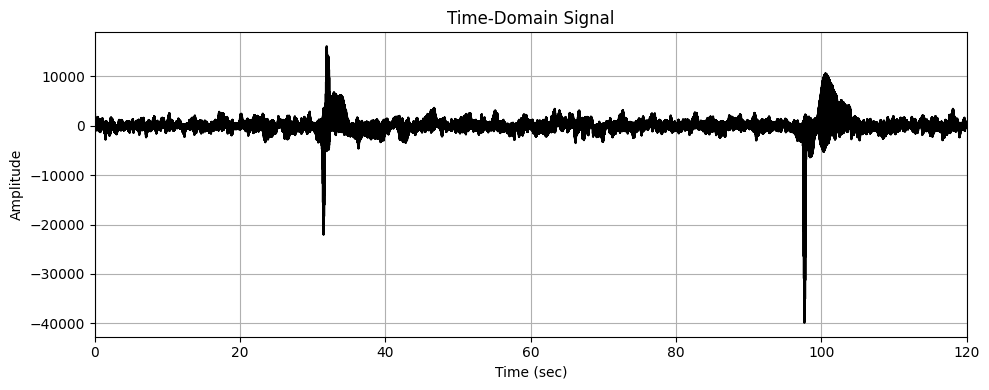

In [ ]:
# from linelength_event_detector import lltransform
from scipy.io import loadmat
from scipy.fft import fft
from scipy.signal import stft

import numpy as np
import mne, glob
from matplotlib import pyplot as plt

mat = loadmat('/content/Linelength-spike-detector-PYTHON/tests/sampledatacopy.mat')
# grab data
data = mat.get('data')
data_to_plot = data.reshape((-1))
print(mat.keys())


# Plot the time-domain signal
fs = 256 #Hz
t = np.arange(data.size) / fs

plt.figure(figsize=(10, 4))
plt.plot(t, data_to_plot, 'k')
plt.title("Time-Domain Signal")
plt.xlabel("Time (sec)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.xlim(0, t[-1])
plt.tight_layout()
plt.show()

data = data.transpose()

# grab sampling frequency
sfx = mat.get('samplingfrequency')
if len(sfx.shape) == 2:
    sfx = sfx[0][0]
elif len(sfx.shape) == 1:
    sfx = sfx[0]

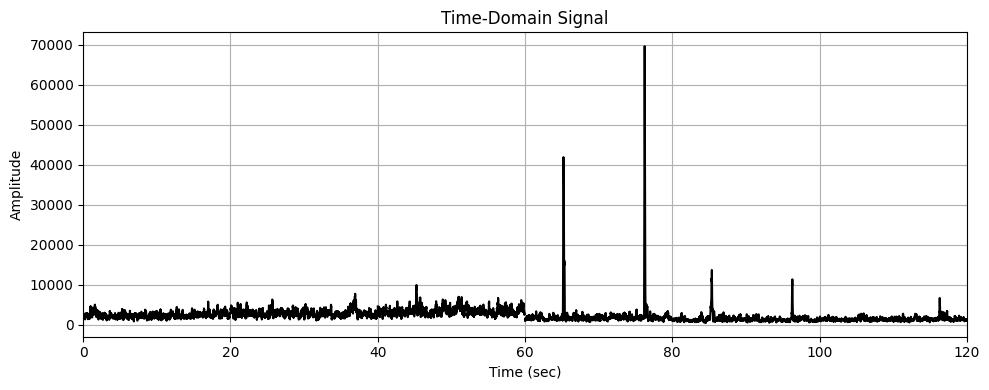

In [ ]:
# CORRECT OUTPUT OF LINE-LENGTH TRANSFORM OF DATA ABOVE
mat = loadmat('/content/Linelength-spike-detector-PYTHON/tests/output.mat')
x = mat.get("L").reshape((-1))
fs = 256 #Hz
t = np.arange(x.size) / fs

plt.figure(figsize=(10, 4))
plt.plot(t, x, 'k')
plt.title("Time-Domain Signal")
plt.xlabel("Time (sec)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.xlim(0, t[-1])
plt.tight_layout()
plt.show()

In [ ]:
expected = mat.get('L')
example_eeg_data = [data, sfx, expected]
l = example_eeg_data[2]
end = len(l[0])
l[1][end - 4:end] = 40000
l[2][end-3] = 40000
sfx = example_eeg_data[1]
actual = lleventdetector(l, sfx, 99.9, 3)
print(actual)

(array([[1344., 1349.],
       [4159., 4180.],
       [5126., 5130.]]), ['3,', '3,', '1,2,'])


In [ ]:
l = example_eeg_data[2]
sfx = example_eeg_data[1]
minimum_event_time = 16
actual = lleventdetector(l, sfx, 99.9, minimum_event_time)
expected_ch = ['3,']
print(actual)

(array([[4159., 4180.]]), ['3,'])
